In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import PIL

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load CNN architecture pretrained on ImageNet
pretrained_model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [4]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)]
)

In [5]:
def fast_gradient_sign_method(model, img, label, epsilon=0.02):
    # Determine prediction of the model
    img.requires_grad = True
    preds = model(img.to(device))
    preds = F.log_softmax(preds, dim=-1)

    print(preds.shape)
    print(label.shape)

    print(preds.argmax(dim=-1))
    print(label)

    # Calculate loss by NLL
    loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
    loss = loss_fn(preds, label)
    print(loss)
    loss.backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(img.grad.to(img.device))
    fake_imgs = img - (epsilon * noise_grad)
    fake_imgs.detach_()
    return fake_imgs.squeeze(0), noise_grad.squeeze(0)

In [6]:
def load_imagenet_classes():
    import urllib.request

    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    class_idx = []
    with urllib.request.urlopen(url) as f:
        for line in f:
            class_idx.append(line.decode("utf-8").strip())
    return class_idx


label_names = load_imagenet_classes()

In [7]:
def show_prediction(
    img: torch.Tensor,
    label: int,
    pred: torch.Tensor,
    K: int = 5,
    adv_img: torch.Tensor = None,
    noise: torch.Tensor = None,
    label_names: list = None,
    NORM_MEAN=(0.485, 0.456, 0.406),
    NORM_STD=(0.229, 0.224, 0.225),
):
    """
    Visualize a single image with its true label, predicted top-K probabilities,
    and optionally adversarial image and noise.

    Args:
        img: Input image tensor, shape (C,H,W).
        label: True label as integer.
        pred: Prediction tensor of shape (num_classes,), logits or probabilities.
        K: Number of top predictions to show.
        adv_img: Optional adversarial image tensor (C,H,W).
        noise: Optional noise tensor (C,H,W).
        label_names: List mapping class indices to class names.
        NORM_MEAN: Normalization mean for unnormalizing the image.
        NORM_STD: Normalization std for unnormalizing the image.
    """

    # Convert input image tensor to numpy RGB image for display
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * np.array(NORM_STD)) + np.array(NORM_MEAN)
    img = np.clip(img, 0, 1)

    if label_names is None:
        label_names = [str(i) for i in range(pred.shape[0])]

    # Setup subplot layout depending on presence of adv_img and noise
    if adv_img is None or noise is None:
        fig, ax = plt.subplots(
            1, 2, figsize=(10, 3), gridspec_kw={"width_ratios": [1, 1]}
        )
    else:
        fig, ax = plt.subplots(
            1, 5, figsize=(14, 3), gridspec_kw={"width_ratios": [1, 1, 1, 0.3, 1]}
        )

    # Show original image
    ax[0].imshow(img)
    ax[0].set_title(f"True: {label_names[label]}")
    ax[0].axis("off")

    # Show adversarial image and noise if provided
    if adv_img is not None and noise is not None:
        adv_img = adv_img.detach().cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * np.array(NORM_STD)) + np.array(NORM_MEAN)
        adv_img = np.clip(adv_img, 0, 1)
        ax[1].imshow(adv_img)
        ax[1].set_title("Adversarial")
        ax[1].axis("off")

        noise = noise.detach().cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5  # scale noise to [0,1]
        ax[2].imshow(noise)
        ax[2].set_title("Noise")
        ax[2].axis("off")

        # small empty space for layout balance
        ax[3].axis("off")

        pred_ax = ax[4]
    else:
        pred_ax = ax[1]

    # Ensure probabilities sum to 1, convert logits if necessary
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)

    topk_vals, topk_idx = pred.topk(K)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()

    # Flatten topk indices
    topk_idx = np.array(topk_idx).flatten()
    topk_vals = np.array(topk_vals).flatten()

    # Build color list
    colors = ["C2" if int(idx) == label else "C0" for idx in topk_idx]

    pred_ax.barh(np.arange(K), topk_vals * 100, color=colors, align="center")

    pred_ax.set_yticks(np.arange(K))
    pred_ax.set_yticklabels([label_names[i] for i in topk_idx])
    pred_ax.invert_yaxis()
    pred_ax.set_xlabel("Confidence (%)")
    pred_ax.set_title("Top Predictions")

    plt.tight_layout()
    plt.show()

In [8]:
img_path = "panda_2.jpg"
img_np = PIL.Image.open(img_path)

# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)]
)

img_tensor = plain_transforms(img_np)
label_int = 368
label = torch.tensor([label_int]).to(device)


# get model predictions
with torch.no_grad():
    pred_before = pretrained_model(img_tensor.unsqueeze(0).to(device))
    pred_before = F.log_softmax(pred_before, dim=-1)

label_pred = torch.argmax(pred_before, dim=-1)

print("Original prediction: ", label_names[label_pred])

print("Expected label: ", label_names[label_int])

Original prediction:  giant panda
Expected label:  gibbon


In [9]:
# get the index of gibbon from labels ame
print(label_names.index("gibbon"))

368


In [10]:
adv_img, noise_grad = fast_gradient_sign_method(
    pretrained_model, img_tensor.unsqueeze(0), label, epsilon=0.02
)
with torch.no_grad():
    adv_pred = pretrained_model(adv_img.to(device).unsqueeze(0))
    pred_label = torch.argmax(adv_pred, dim=-1)

print("Original prediction: ", label_names[label_pred])

print("Expected label: ", label_names[label_int])

print("Adversarial prediction: ", pred_label, label_names[pred_label])

torch.Size([1, 1000])
torch.Size([1])
tensor([388])
tensor([368])
tensor(16.3628, grad_fn=<NllLossBackward0>)
Original prediction:  giant panda
Expected label:  gibbon
Adversarial prediction:  tensor([368]) gibbon


In [11]:
print(adv_img.shape)
print(noise_grad.shape)
print(label_int)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
368


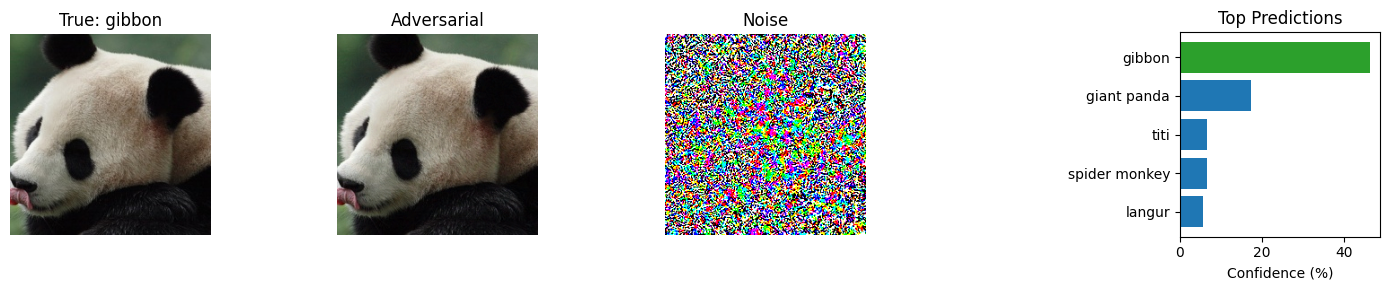

In [12]:
show_prediction(
    img_tensor,
    label_int,
    adv_pred,
    adv_img=adv_img,
    noise=noise_grad,
    label_names=label_names,
)

In [17]:
import sys
import os

# Add the parent directory (project root) to sys.path
sys.path.insert(0, os.path.abspath(".."))

from adverserial_noise.attacks.fgsma_attack import FGSMAttack
from adverserial_noise.attacks.base.pytorch_interface import PyTorchBackend

In [18]:
img_path = "panda_2.jpg"
img_np = PIL.Image.open(img_path)

# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)]
)

img_tensor = plain_transforms(img_np)
label_int = 368
label = torch.tensor([label_int]).to(device)

In [19]:
py_backend = PyTorchBackend()
fgsma_attack = FGSMAttack(
    backend=py_backend, epsilon=0.02, loss_fn=torch.nn.CrossEntropyLoss(reduction="sum")
)

adv_img_2, noise_grad_2 = fgsma_attack._perturb(
    pretrained_model, img_tensor.unsqueeze(0), label
)
with torch.no_grad():
    adv_pred = pretrained_model(adv_img_2.to(device).unsqueeze(0))
    pred_label = torch.argmax(adv_pred, dim=-1)

print("Original prediction: ", label_names[label_pred])

print("Expected label: ", label_names[label_int])

print("Adversarial prediction: ", pred_label, label_names[pred_label])

torch.Size([1, 3, 224, 224])
torch.Size([1])
tensor(16.3628, grad_fn=<NllLossBackward0>)
Original prediction:  giant panda
Expected label:  gibbon
Adversarial prediction:  tensor([368]) gibbon


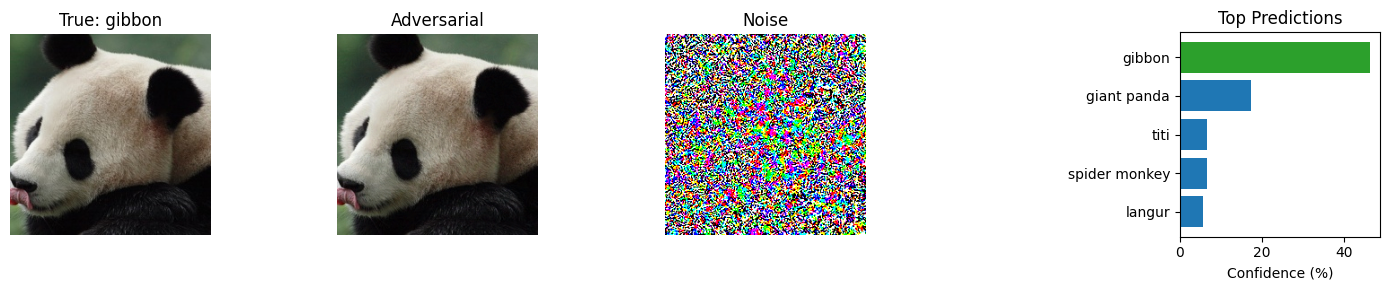

In [20]:
show_prediction(
    img_tensor,
    label_int,
    adv_pred,
    adv_img=adv_img_2,
    noise=noise_grad_2,
    label_names=label_names,
)